In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [3]:
data_dir = "/kaggle/input/sarscov2-ctscan-dataset"
SEED = 0

In [4]:
train_ds_ = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    validation_split=0.2,
    subset="training",
    interpolation='nearest',
    batch_size=64,
    seed=SEED)

valid_ds_ = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    validation_split=0.2,
    subset="validation",
    interpolation='nearest',
    batch_size=64,
    seed=SEED
)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.


2022-12-21 17:19:04.530666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:19:04.670617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:19:04.671492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:19:04.674193: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2481 files belonging to 2 classes.
Using 496 files for validation.


In [5]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
valid_ds = (
    valid_ds_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


2022-12-21 17:19:07.883764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


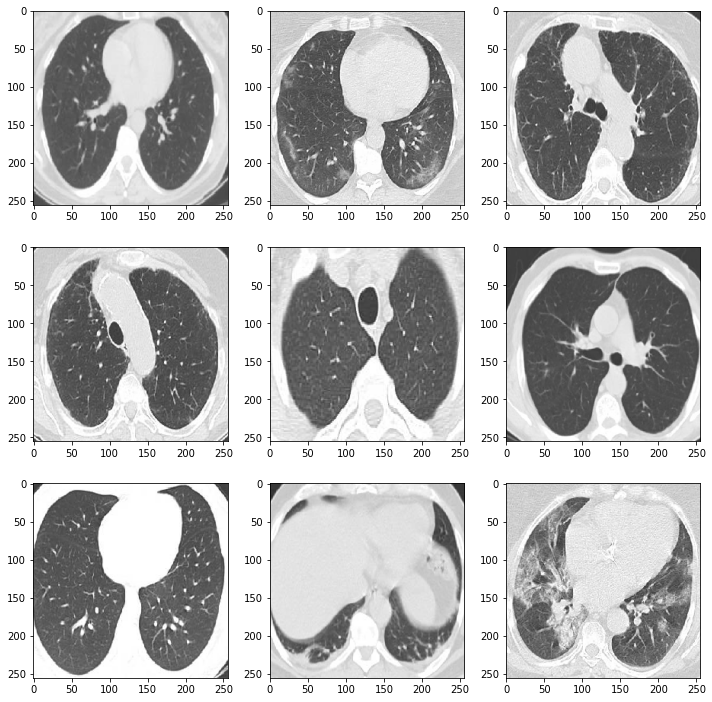

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

In [7]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [8]:
base_incv3 = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    pooling="max",
    input_shape=(256,256,3)
)

base_vgg16 = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    pooling="max",
    input_shape=(256,256,3)
)

base_resnet50 = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    pooling="max",
    input_shape=(256,256,3)
)

base_xception = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    pooling="max",
    input_shape=(256,256,3)
)

83697664/83683744 [==============================] - 1s 0us/step


In [9]:
bases = [base_vgg16, base_resnet50, base_xception, base_incv3]

In [10]:
def model_hist(base, train_ds, valid_ds):
    testbase = base;
    testbase.trainable = False
    
    input = keras.Input(shape=(256,256,3))

    x = base(input, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=0.3)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=0.3)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=0.3)(x)
    x = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs=input, outputs=x)
    opt = keras.optimizers.Adam(learning_rate=0.02)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["binary_accuracy"])
    
    earlyStop = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
    LR = keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-4, verbose=1)
    
    hist = model.fit(train_ds, epochs=50, callbacks=[earlyStop, LR], validation_data=valid_ds, verbose=1)
    
    return hist

In [11]:
def get_model_history(bases, train_ds, valid_ds):
    histories=[]
    for base in bases:
        x = model_hist(base, train_ds, valid_ds)
        histories.append(x)
    
    return histories

In [12]:
# df = pd.DataFrame(hist.history)
# df.loc[:, ['loss', 'val_loss']].plot()
# df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [13]:
# model_histories = get_model_history(bases, train_ds, valid_ds)

In [14]:
# type(model_histories)

In [15]:
labels = ["VGG16", "ResNet50", "Xception", "InceptionV3"]

def plot_hist(model_histories):
    for i in range(len(model_histories)):
        figure, axis = plt.subplots(1, 2)
        #accuracy plot
        axis[0].plot(model_histories[i].history['binary_accuracy'])
        axis[0].plot(model_histories[i].history['val_binary_accuracy'])
        axis[0].set_title(labels[i]+" accuracy")
        axis[0].set_ylabel('accuracy')
        axis[0].set_xlabel('epoch')
        axis[0].legend(['train', 'test'], loc='upper left')
        #loss plot
        axis[1].plot(model_histories[i].history['loss'])
        axis[1].plot(model_histories[i].history['val_loss'])
        axis[1].set_title(labels[i]+" loss")
        axis[1].set_ylabel('loss')
        axis[1].set_xlabel('epoch')
        axis[1].legend(['train', 'test'], loc='upper left')
        plt.show()

In [16]:
# plot_hist(model_histories)

resnet50 and xception perform best

In [17]:
base = base_resnet50
base.trainable = False

In [18]:
# base.summary()

In [19]:
input = keras.Input(shape=(256,256,3))

x = base(input, training=False)
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate=0.3)(x)
x = layers.Dense(units=128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate=0.3)(x)
x = layers.Dense(units=64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate=0.3)(x)
x = layers.Dense(units=1, activation="sigmoid")(x)

model = keras.Model(inputs=input, outputs=x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization_98 (Batc (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512 

In [21]:
opt = keras.optimizers.Adam(learning_rate=0.02)

In [22]:
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["binary_accuracy"])

In [23]:
earlyStop = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
LR = keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-4, verbose=1)

In [24]:
history = model.fit(train_ds, epochs=100, callbacks=[earlyStop, LR], validation_data=valid_ds, verbose=1)

Epoch 1/100


2022-12-21 17:19:29.242977: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


32/32 [==============================] - 28s 513ms/step - loss: 0.6912 - binary_accuracy: 0.6418 - val_loss: 61.3323 - val_binary_accuracy: 0.4798
Epoch 2/100
32/32 [==============================] - 5s 157ms/step - loss: 0.4622 - binary_accuracy: 0.7834 - val_loss: 29.1050 - val_binary_accuracy: 0.4798
Epoch 3/100
32/32 [==============================] - 5s 159ms/step - loss: 0.3978 - binary_accuracy: 0.8287 - val_loss: 31.7247 - val_binary_accuracy: 0.4798
Epoch 4/100
32/32 [==============================] - 5s 159ms/step - loss: 0.3576 - binary_accuracy: 0.8433 - val_loss: 6.1263 - val_binary_accuracy: 0.4879
Epoch 5/100
32/32 [==============================] - 5s 157ms/step - loss: 0.3374 - binary_accuracy: 0.8610 - val_loss: 1.4933 - val_binary_accuracy: 0.6552
Epoch 6/100
32/32 [==============================] - 5s 160ms/step - loss: 0.3187 - binary_accuracy: 0.8705 - val_loss: 2.5639 - val_binary_accuracy: 0.6250
Epoch 7/100
32/32 [==============================] - 5s 158ms/step

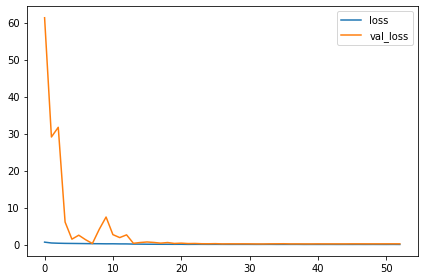

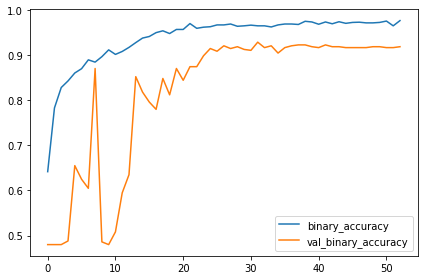

In [25]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [26]:
model.save("covid19-resnet50.h5")